## Notebook 3 - Author Identification

In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [9]:
#pip install -U regex

In [4]:
pd.set_option("max_colwidth", 100)

In [5]:
from google.cloud import storage
# !pip install gcsfs --upgrade

### Setting Up Helper Functions

In [6]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

### Accessing Filtered Database

In [7]:
twitter_df4= spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/kshitijm/Final_Project-FiltData3')

In [14]:
twitter_df4.count()

27102994

In [8]:
twitter_df4.limit(15)

23/03/09 22:43:37 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type
1566378682318462976,Sun Sep 04 10:52:...,RT @C_A_Graham: H...,had another conve...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566034383559065601,C_A_Graham,483864332,erin_gilbey,Storyteller and 1...,"Birmingham, England",false,442,601,8,15433,8431,Sun Feb 05 13:37:...,https://pbs.twimg...,[],retweet
1566378688698097664,Sun Sep 04 10:52:...,RT @Oludeewon: I ...,i hope you have s...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566165377796771840,Oludeewon,984182548791164928,Odeshiye,♎ ...So A Child M...,Ghana,false,4902,4613,3,149571,92052,Wed Apr 11 21:32:...,https://pbs.twimg...,[],retweet
1566378715709427719,Sun Sep 04 10:52:...,RT @JackPosobiec:...,breaking: @trinit...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1565431877460189189,JackPosobiec,1558859689789644800,EuroAmerican87,American by birth...,Anywhere but here...,false,6,34,1,50,89,Sun Aug 14 16:54:...,https://pbs.twimg...,[],retweet
1566378716887916546,Sun Sep 04 10:52:...,RT @amishra77: Th...,the appalling con...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566378309520596993,amishra77,1279643153474224130,Bharath12450842,One of the 900 mi...,null,false,193,502,0,6244,9146,Sun Jul 05 05:09:...,https://pbs.twimg...,[],retweet
1566378724135555072,Sun Sep 04 10:52:...,RT @imzarvinnn: S...,senior high schoo...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566034947831660545,imzarvinnn,1530893925803622401,lvchdvmp,I'm counting on y...,archen's heart,false,341,458,0,11632,5624,Sun May 29 12:49:...,https://pbs.twimg...,[],retweet
1566378734529101824,Sun Sep 04 10:52:...,RT @imzarvinnn: S...,senior high schoo...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566034947831660545,imzarvinnn,1398282464854827012,doyiea_,she/her ...,null,false,1,91,0,59,621,Fri May 28 14:18:...,https://pbs.twimg...,[],retweet
1566378741508734976,Sun Sep 04 10:52:...,You can also tag ...,you can also tag ...,null,null,null,null,null,true,false,,0,0,0,0,1566378738438533120,1299666479344807937,thxteacher,null,null,null,1299666479344807937,thxteacher,Our Teachers are ...,null,false,902,69,1,325,1257,Sat Aug 29 11:13:...,https://pbs.twimg...,"[TeachersDay, Tha...",reply
1566378743710744576,Sun Sep 04 10:52:...,RT @cutedevil5934...,"""teachers play a ...",null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566366649912938498,cutedevil5934,769516988335067137,shoaibAlam28,http://Instagram....,"Jamui, India",false,85,146,0,1434,5245,Sat Aug 27 12:48:...,https://pbs.twimg...,[],retweet
1566378745539469312,Sun Sep 04 10:52:...,@jenqissante ! 🧚...,@jenqissante ! 🧚...,null,null,null,null,null,true,true,,0,0,0,0,1566373182810234882,1547185772708909056,jenqissante,1496397166339932162,null,null,1307586299893702656,PaperupPh,more than 1k+ wor...,10AM-10PM,false,520,182,2,95,820,Sun Sep 20 07:44:...,https://pbs.twimg...,[],quote
1566378750090027008,Sun Sep 04 10:52:...,RT @SethAbramson:...,like... one of hi...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566236400785264640,SethAbramson,1269070500082450437,ResisterNell,"Activist, #Resist...",Kentucky,false,9745,10379,16,463255,333552,Sat Jun 06 00:57:...,https://pbs.twimg...,[],retweet


In [15]:
twitter_df4.select('is_verified').groupby('is_verified').count().show()

+-----------+--------+
|is_verified|   count|
+-----------+--------+
|       true|  577459|
|      false|26525535|
+-----------+--------+



In [3]:
twitter_df4.createOrReplaceTempView("twitter_df4")

query = ''' SELECT COUNT(*) as num_tweets,
COUNT(DISTINCT account_id) as num_accounts 
FROM twitter_df4 
GROUP BY is_verified'''

23/03/07 20:10:30 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [20]:
num_verified_accounts = spark.sql(query)

In [21]:
num_verified_accounts.show()

+----------+------------+
|num_tweets|num_accounts|
+----------+------------+
|    577459|       90892|
|  26525535|     7330492|
+----------+------------+



-----------
### We have only 90,000 verified accounts when compared with 7.3 million other accounts in our dataset
### We will be analysing these users

In [14]:
twitter_df4_ver_user=twitter_df4.filter("is_verified = True")

In [24]:
twitter_df4_ver_user.count()

577459

In [15]:
twitter_df4_ver_user = twitter_df4_ver_user\
.withColumn('account_description', lower('account_description'))\
.withColumn('account_description', regexp_replace(col("account_description"),"[\$#,&%\".]",""))

In [13]:
twitter_df4_ver_user.limit(15)

DataFrame[id: bigint, created_at: string, text: string, tweet_text: string, tweet_coordinates: array<double>, tweet_country: string, tweet_country_code: string, tweet_place_full_name: string, tweet_place_type: string, is_reply: boolean, is_quote: boolean, is_retweeted: string, reply_count: bigint, quote_count: bigint, retweet_count: bigint, favorite_count: bigint, rp_original_id: bigint, rp_user_id: bigint, rp_original_user: string, qu_original_id: bigint, rt_original_id: bigint, rt_original_user: string, account_id: bigint, account_name: string, account_description: string, account_location: string, is_verified: boolean, total_followers: bigint, total_friends: bigint, total_listed: bigint, total_favourites: bigint, total_tweets: bigint, account_created_at: string, account_profile_picture: string, hashtags: array<string>, tweet_type: string]

In [ ]:
twitter_df4_ver_user.write.format("parquet").\
mode('overwrite').\
save('gs://' + 'msca-bdp-students-bucket/shared_data/kshitijm' + '/Final_Project-FiltData4_Ver_Users')

--------

In [17]:
twitter_df4_ver_user= spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/kshitijm/Final_Project-FiltData4_Ver_Users')


In [19]:
twitter_df4_ver_user.limit(10)

id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type
1539335995845402624,Tue Jun 21 19:54:...,RT @NSEAOnline: P...,public dollars sh...,null,null,null,null,null,false,true,RT,0,0,0,0,null,null,null,1539262288053833728,1539316518202138624,NSEAOnline,22789766,NEAToday,official account ...,Washington DC,true,247738,11834,4148,8048,27669,Wed Mar 04 15:51:...,https://pbs.twimg...,[],retweet
1539336083649048577,Tue Jun 21 19:54:...,RT @JasonBedrick:...,@wajahatali what ...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1539289355449028608,JasonBedrick,640893,EWErickson,you can listen ev...,"Atlanta, GA",true,205722,2700,4633,1384,14273,Mon Jan 15 22:54:...,https://pbs.twimg...,[],retweet
1539336297814319104,Tue Jun 21 19:55:...,RT @itsSpencerBro...,scotus handed a b...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1539328635613630464,itsSpencerBrown,48459553,KatiePavlich,proud american wo...,On Instagram/Off ...,true,947092,2009,4472,18188,55802,Thu Jun 18 19:29:...,https://pbs.twimg...,[],retweet
1539336371936051200,Tue Jun 21 19:56:...,One of Louisiana'...,one of louisiana'...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,44426926,FOX8NOLA,wvue - fox 8 is y...,New Orleans,true,217913,2853,1241,1350,207940,Wed Jun 03 18:57:...,https://pbs.twimg...,[],original_tweet
1539336396971859968,Tue Jun 21 19:56:...,@hales_ted But th...,@hales_ted but th...,null,null,null,null,null,true,false,,0,0,0,0,1539335979336470528,1445063896725819398,hales_ted,null,null,null,738538436,AoDespair,author journalist...,"Baltimore, MD",true,334054,610,2732,5818,97431,Sun Aug 05 12:53:...,https://pbs.twimg...,[],reply
1539336533509132289,Tue Jun 21 19:56:...,Congratulations t...,congratulations t...,null,null,null,null,null,true,false,,0,0,0,0,1539329196379541509,16240525,ASBMB,null,null,null,16240525,ASBMB,american society ...,"Rockville, Maryland",true,24963,4259,0,14868,40004,Thu Sep 11 14:05:...,https://pbs.twimg...,[],reply
1539336550730842115,Tue Jun 21 19:56:...,.@JimGrossmanAHA ...,.@jimgrossmanaha ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,76944176,AHAhistorians,the american hist...,"Washington, D.C.",true,55451,2362,1105,8000,32842,Thu Sep 24 13:54:...,https://pbs.twimg...,[],original_tweet
1539336562814623745,Tue Jun 21 19:56:...,RT @FOX8NOLA: One...,one of louisiana'...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1539336371936051200,FOX8NOLA,30950114,jessecbrooks,digital content p...,"New Orleans, LA",true,3442,1741,71,46045,82432,Mon Apr 13 20:23:...,https://pbs.twimg...,[],retweet
1539336614966599681,Tue Jun 21 19:57:...,Graduation 2022: ...,graduation 2022: ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,16477702,syracusedotcom,syracuse and cent...,"Syracuse, NY",true,102116,589,829,190,227817,Sat Sep 27 00:17:...,https://pbs.twimg...,[],original_tweet
1539336707958616068,Tue Jun 21 19:57:...,@UConnBSB Great n...,@uconnbsb great n...,null,null,null,null,null,true,false,,0,0,0,0,1539332632739123200,491571741,UConnBSB,null,null,null,3836570273,jdesnoyersabc6,chief meteorologi...,"Providence, RI",true,3743,1091,56,31024,26502,Thu Oct 01 20:26:...,https://pbs.twimg...,"[Bitter, HookC]",reply


In [10]:
twitter_df4_ver_user.count()

577459

### Analysing different types of twitter accounts

In [117]:
govt = ['government','govt','administration',
        'governing','state','judiciary','potus','president','political'
        'prime','minister','governor','administer','centre',
       'ministry','niti','board','federal','agency','embassy','embassies','province','state',
       'outpost','conservative','politic','democrat','republican','senate','county','counties','district','first lady','first person','commision']

education = ['college','university','academia','campus','school',
             'teach','teachers','educators','educator','ivy','professor','univ','alum',
            'alumni','alumnus','career','graduate','grad','education']

research = ['institute','research','science','scientific','explore','society','conference','policy','think tank','development',
           'united nation','unhrc','unhcr','unicef','who','world bank','imf','wef','forum','researcher','non profit','non-profit',
           'non-governmental','non governmental','aid','assistance','nonprofit','nongovernmental','ngo','npo',
           'federation']

news=['news','bulletin','press','pti',
      'reuters','cnn','breaking','bbc','times','economist','post','times',
     'abc','television','ndtv','xinhua','huffington','guardian','sky news',
     'al jazeera','cnbc','politico','newspaper','newsweek','telegraph','rt','MSNBC','pioneer',
     'journalist','reporter','author','writer','analyst','chief','editor','correspondent','columnist']

news_outlet=['news','bulletin','press','pti',
      'reuters','cnn','breaking','bbc','times','economist','post','times',
     'abc','television','ndtv','xinhua','huffington','guardian','sky news',
     'al jazeera','cnbc','politico','newspaper','newsweek','telegraph','rt','MSNBC','pioneer']

news_journalist = ['journalist','reporter','author','writer','analyst','chief','editor','correspondent','columnist']


In [102]:
govt

['government',
 'govt',
 'administration',
 'governing',
 'state',
 'judiciary',
 'potus',
 'president',
 'politicalprime',
 'minister',
 'governor',
 'administer',
 'centre',
 'ministry',
 'niti',
 'board',
 'federal',
 'agency',
 'embassy',
 'embassies',
 'province',
 'state',
 'outpost',
 'conservative',
 'politic',
 'democrat',
 'republican',
 'senate',
 'county',
 'counties',
 'district',
 'first lady',
 'first person',
 'commision']

In [89]:
twitter_df4_ver_user=twitter_df4_ver_user.\
withColumn('is_user_govt',\
           ((col('account_name').rlike('|'.join(govt))) | (col('account_description').rlike('|'.join(govt))))
          ).\
withColumn('is_user_news',\
           ((col('account_name').rlike('|'.join(news))) | (col('account_description').rlike('|'.join(news))))
          ).\
withColumn('is_user_news_outlet',\
           ((col('account_name').rlike('|'.join(news_outlet))) | (col('account_description').rlike('|'.join(news_outlet))))
          ).\
withColumn('is_user_news_journalist',\
           ((col('account_name').rlike('|'.join(news_journalist))) | (col('account_description').rlike('|'.join(news_journalist))))
          ).\
withColumn('is_user_edu',\
           ((col('account_name').rlike('|'.join(education))) | (col('account_description').rlike('|'.join(education))))
          ).\
withColumn('is_user_research',\
           ((col('account_name').rlike('|'.join(research))) | (col('account_description').rlike('|'.join(research))))
          ).\
withColumn('is_influencer',\
           when(col('total_followers')>50000,'social_media_influencer').\
           when(col('total_followers')>5000,'micro_influencer').\
           otherwise('not_influencer')
          )

In [22]:
twitter_df4_ver_user.limit(30)

id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type,is_user_govt,is_user_news_outlet,is_user_news_journalist,is_user_edu,is_user_research,is_influencer
1539335995845402624,Tue Jun 21 19:54:...,RT @NSEAOnline: P...,public dollars sh...,null,null,null,null,null,false,true,RT,0,0,0,0,null,null,null,1539262288053833728,1539316518202138624,NSEAOnline,22789766,NEAToday,official account ...,Washington DC,true,247738,11834,4148,8048,27669,Wed Mar 04 15:51:...,https://pbs.twimg...,[],retweet,false,false,false,true,true,social_media_infl...
1539336083649048577,Tue Jun 21 19:54:...,RT @JasonBedrick:...,@wajahatali what ...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1539289355449028608,JasonBedrick,640893,EWErickson,you can listen ev...,"Atlanta, GA",true,205722,2700,4633,1384,14273,Mon Jan 15 22:54:...,https://pbs.twimg...,[],retweet,false,false,false,false,false,social_media_infl...
1539336297814319104,Tue Jun 21 19:55:...,RT @itsSpencerBro...,scotus handed a b...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1539328635613630464,itsSpencerBrown,48459553,KatiePavlich,proud american wo...,On Instagram/Off ...,true,947092,2009,4472,18188,55802,Thu Jun 18 19:29:...,https://pbs.twimg...,[],retweet,false,false,false,false,false,social_media_infl...
1539336371936051200,Tue Jun 21 19:56:...,One of Louisiana'...,one of louisiana'...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,44426926,FOX8NOLA,wvue - fox 8 is y...,New Orleans,true,217913,2853,1241,1350,207940,Wed Jun 03 18:57:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,true,social_media_infl...
1539336396971859968,Tue Jun 21 19:56:...,@hales_ted But th...,@hales_ted but th...,null,null,null,null,null,true,false,,0,0,0,0,1539335979336470528,1445063896725819398,hales_ted,null,null,null,738538436,AoDespair,author journalist...,"Baltimore, MD",true,334054,610,2732,5818,97431,Sun Aug 05 12:53:...,https://pbs.twimg...,[],reply,false,true,true,false,true,social_media_infl...
1539336533509132289,Tue Jun 21 19:56:...,Congratulations t...,congratulations t...,null,null,null,null,null,true,false,,0,0,0,0,1539329196379541509,16240525,ASBMB,null,null,null,16240525,ASBMB,american society ...,"Rockville, Maryland",true,24963,4259,0,14868,40004,Thu Sep 11 14:05:...,https://pbs.twimg...,[],reply,false,false,false,false,true,not_influencer
1539336550730842115,Tue Jun 21 19:56:...,.@JimGrossmanAHA ...,.@jimgrossmanaha ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,76944176,AHAhistorians,the american hist...,"Washington, D.C.",true,55451,2362,1105,8000,32842,Thu Sep 24 13:54:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,social_media_infl...
1539336562814623745,Tue Jun 21 19:56:...,RT @FOX8NOLA: One...,one of louisiana'...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1539336371936051200,FOX8NOLA,30950114,jessecbrooks,digital content p...,"New Orleans, LA",true,3442,1741,71,46045,82432,Mon Apr 13 20:23:...,https://pbs.twimg...,[],retweet,false,false,true,false,false,not_influencer
1539336614966599681,Tue Jun 21 19:57:...,Graduation 2022: ...,graduation 2022: ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,16477702,syracusedotcom,syracuse and cent...,"Syracuse, NY",true,102116,589,829,190,227817,Sat Sep 27 00:17:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,true,social_media_infl...
1539336707958616068,Tue Jun 21 19:57:...,@UConnBSB Great n...,

In [90]:
twitter_df4_ver_user=twitter_df4_ver_user.\
withColumn('user_type',\
           when(col('is_user_news_journalist')=='true','News_Journalist').\
           when(col('is_user_news_outlet')=='true','News_Outlet').\
           when(col('is_user_edu')=='true','Educational_Inst').\
           when(col('is_user_govt')=='true','Government').\
           when(col('is_user_research')=='true','Research_Inst').\
           when(col('is_influencer')=='social_media_influencer','Influencer').\
           when(col('is_influencer')=='micro_influencer','Micro_Influencer').\
           otherwise('Others')
          )

In [24]:
twitter_df4_ver_user.select('account_id','user_type').distinct().count()

96680

In [91]:
twitter_df4_ver_user.select('account_id','user_type').distinct().groupby('user_type').count().show()

+----------------+-----+
|       user_type|count|
+----------------+-----+
|Micro_Influencer|10943|
|      Government|15856|
|      Influencer| 6404|
| News_Journalist|20254|
|Educational_Inst|15055|
|   Research_Inst| 3032|
|          Others| 4803|
|     News_Outlet|19713|
+----------------+-----+



### Analysing other account type to see if we have any new missing categories

In [92]:
twitter_df4_ver_user_2=twitter_df4_ver_user

In [82]:
twitter_df4_ver_user_2.filter(col("user_type") == 'Others').orderBy(col('total_followers').desc()).limit(15)

id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type,is_user_govt,is_user_news_outlet,is_user_news_journalist,is_user_edu,is_user_research,is_influencer,user_type
1522019017510301698,Thu May 05 01:03:...,You’re always tau...,you’re always tau...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,38989894,ZackFradellaWx,meteorologist @fo...,Louisiana,true,4998,793,142,1326,10136,Sun May 10 03:45:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,not_influencer,Others
1581985913139515392,Mon Oct 17 12:30:...,Read how Michelle...,read how michelle...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,39516928,infotechRG,we help it leader...,"Toronto, ON",true,4997,4135,165,1708,4040,Tue May 12 15:01:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,not_influencer,Others
1564951831289143296,Wed Aug 31 12:22:...,This reminds me o...,this reminds me o...,null,null,null,null,null,false,true,,0,0,0,0,null,null,null,1564775887433875461,null,null,819884103868776449,BerndBuchmasser,the folks at @sbn...,null,true,4997,663,198,19320,22767,Fri Jan 13 12:29:...,https://pbs.twimg...,[],quote,false,false,false,false,false,not_influencer,Others
1542953695054385152,Fri Jul 01 19:30:...,One of FCSL’s pro...,one of fcsl’s pro...,null,null,null,null,null,true,false,,0,0,0,0,1542953130706587649,9217222,jdasilva,null,null,null,9217222,jdasilva,magical mindset m...,"Tallahassee, FL",true,4996,946,138,2601,6957,Wed Oct 03 01:24:...,https://pbs.twimg...,[],reply,false,false,false,false,false,not_influencer,Others
1605948473953525760,Thu Dec 22 15:28:...,"Since 2017, Canad...","since 2017, canad...",null,null,null,null,null,true,false,,0,0,0,0,1605948471026094084,2571158671,CanadaJamaica,null,null,null,2571158671,CanadaJamaica,high commission o...,"Kingston, Jamaica",true,4996,417,94,1751,5268,Mon Jun 16 15:28:...,https://pbs.twimg...,[],reply,false,false,false,false,false,not_influencer,Others
1529486235131158529,Wed May 25 15:35:...,The @JolietPolice...,the @jolietpolice...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,421128680,JolietPolice,official twitter ...,"Joliet, IL",true,4996,185,84,33,1560,Fri Nov 25 14:55:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,not_influencer,Others
1603904611370389510,Sat Dec 17 00:07:...,Congratulations t...,congratulations t...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,2571158671,CanadaJamaica,high commission o...,"Kingston, Jamaica",true,4996,417,93,1743,5255,Mon Jun 16 15:28:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,not_influencer,Others
1570167423105392640,Wed Sep 14 21:47:...,RT @NPerkins96: A...,arkansas state ha...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1569870245057253377,NPerkins96,61013482,benjaminwolk,least verified pe...,"Athens, GA",true,4994,1010,0,11391,24512,Tue Jul 28 20:42:...,https://pbs.twimg...,[],retweet,false,false,false,false,false,not_influencer,Others
1541562607139782657,Mon Jun 27 23:22:...,RT @briantylercoh...,i was the only je...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1541518328128163840,briantylercohen,147304867,erichmcelroy,erich does comedy...,Lockdown,true,4994,2619,73,17712,27698,Sun May 23 19:39:...,https://pbs.twimg...,[],retweet,false,false,false,false,false,not_influencer,Others
1542891059625316352,Fri Jul 01 15:21:...,RT @AndreaM_idd: ...,“schools are in t...,null,nul

In [ ]:
twitter_df4_ver_user_2.filter(col("user_type") == 'Research_Inst').orderBy(col('total_followers').desc()).limit(15)

id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type,is_user_govt,is_user_news_outlet,is_user_news_journalist,is_user_edu,is_user_research,is_influencer,user_type
1517937985542451201,Sat Apr 23 18:46:...,Michigan edge rus...,michigan edge rus...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,19426551,NFL,who's going no 1 ...,null,true,29787658,2752,50781,3185,236305,Sat Jan 24 01:28:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,true,social_media_infl...,Research_Inst
1619622250390470656,Sun Jan 29 09:03:...,The devastating f...,the devastating f...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,14159148,UN,official account ...,"New York, NY",true,16198463,1208,45156,1650,89013,Sun Mar 16 20:15:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,true,social_media_infl...,Research_Inst
1615144452762247171,Tue Jan 17 00:30:...,RT @UNOCHA: The d...,the death toll co...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1615045742963396616,UNOCHA,14159148,UN,official account ...,"New York, NY",true,16174064,1208,45027,1650,88859,Sun Mar 16 20:15:...,https://pbs.twimg...,[Dnipro],retweet,false,false,false,false,true,social_media_infl...,Research_Inst
1615031501283786752,Mon Jan 16 17:01:...,Civilians are #No...,civilians are #no...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,14159148,UN,official account ...,"New York, NY",true,16173605,1208,45030,1650,88852,Sun Mar 16 20:15:...,https://pbs.twimg...,"[NotATarget, NotA...",original_tweet,false,false,false,false,true,social_media_infl...,Research_Inst
1605745185870192640,Thu Dec 22 02:01:...,"""I am deeply shoc...","""i am deeply shoc...",null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,14159148,UN,official account ...,"New York, NY",true,16127722,1209,44904,1650,88526,Sun Mar 16 20:15:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,true,social_media_infl...,Research_Inst
1589392433783226368,Sun Nov 06 23:01:...,"""No child is born...","""no child is born...",null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,14159148,UN,official account ...,"New York, NY",true,16067745,1206,44897,1646,87789,Sun Mar 16 20:15:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,true,social_media_infl...,Research_Inst
1584447147876835329,Mon Oct 24 07:30:...,RT @antonioguterr...,"last year, @un co...",null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1584318758759251969,antonioguterres,14159148,UN,official account ...,"New York, NY",true,16035592,1205,45002,1644,87562,Sun Mar 16 20:15:...,https://pbs.twimg...,[COVID19],retweet,false,false,false,false,true,social_media_infl...,Research_Inst
1579683710047117313,Tue Oct 11 04:02:...,Nearly 130 millio...,nearly 130 millio...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,14159148,UN,official account ...,"New York, NY",true,15992952,1205,44911,1661,87359,Sun Mar 16 20:15:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,true,social_media_infl...,Research_Inst
1571562126296186882,Sun Sep 18 18:09:...,RT @antonioguterr...,sunday marks one ...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1571355835351064577,antonioguterres,14159148,UN,official account ...,"New York, NY",true,15885244,1204,44785,1625,86931,Sun Mar 16 20:15:...,https://pbs.twimg...,[],retweet,false,false,false,false,true,social_media_infl...,Resea

In [94]:
twitter_df4_ver_user_2.filter(col("user_type") == 'Government').orderBy(col('total_followers').desc()).limit(15)

id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type,is_user_govt,is_user_news_outlet,is_user_news_journalist,is_user_edu,is_user_research,is_influencer,user_type
1582744875539144704,Wed Oct 19 14:45:...,Today is a landma...,today is a landma...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,18839785,narendramodi,prime minister of...,India,true,83552404,2447,29184,0,34369,Sat Jan 10 17:18:...,https://pbs.twimg...,[],original_tweet,true,false,false,false,false,social_media_infl...,Government
1582745691440709632,Wed Oct 19 14:49:...,Some glimpses fro...,some glimpses fro...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,18839785,narendramodi,prime minister of...,India,true,83549828,2447,29180,0,34370,Sat Jan 10 17:18:...,https://pbs.twimg...,[],original_tweet,true,false,false,false,false,social_media_infl...,Government
1582971758394585089,Thu Oct 20 05:47:...,"Students, teacher...","students, teacher...",null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,471741741,PMOIndia,office of the pri...,India,true,51115349,504,13501,3,33150,Mon Jan 23 06:24:...,https://pbs.twimg...,[],original_tweet,true,false,false,false,false,social_media_infl...,Government
1565007006443995138,Wed Aug 31 16:02:...,We’ve come a long...,we’ve come a long...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,939091,JoeBiden,husband to @drbid...,"Washington, DC",true,35277351,48,39819,20,8444,Sun Mar 11 17:51:...,https://pbs.twimg...,[],original_tweet,true,false,false,false,false,social_media_infl...,Government
1542896060787482626,Fri Jul 01 15:41:...,Bipartisan member...,bipartisan member...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,939091,JoeBiden,husband to @drbid...,"Washington, DC",true,34631362,48,39362,20,8314,Sun Mar 11 17:51:...,https://pbs.twimg...,[],original_tweet,true,false,false,false,false,social_media_infl...,Government
1529261744970924032,Wed May 25 00:43:...,RT @POTUS: I’m ad...,i’m addressing th...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1529261342011670535,POTUS,939091,JoeBiden,husband to @drbid...,"Washington, DC",true,34297724,48,39149,20,8231,Sun Mar 11 17:51:...,https://pbs.twimg...,[],retweet,true,false,false,false,false,social_media_infl...,Government
1529253343415222274,Wed May 25 00:09:...,RT @BillClinton: ...,my statement on t...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1529250928351756290,BillClinton,1339835893,HillaryClinton,2016 democratic n...,"New York, NY",true,31501665,960,42414,1171,13415,Tue Apr 09 18:04:...,https://pbs.twimg...,[],retweet,true,false,false,false,false,social_media_infl...,Government
1566800757852033024,Mon Sep 05 14:49:...,Inaugurated the A...,inaugurated the a...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,1447949844,AmitShah,union home minist...,null,true,30592690,311,5963,80,17382,Wed May 22 04:43:...,https://pbs.twimg...,[],original_tweet,true,false,false,false,false,social_media_infl...,Government
1527189451285606401,Thu May 19 07:28:...,Addressing a semi...,addressing a semi...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,1447949844,AmitShah,union home minist...,null,true,29473229,309,5729,87,16363,Wed May 22 04:43:...,https://pbs.twimg...,[],original_tweet,true,false,false,false,false,social_media_infl...,Government
1527153565633875968,Thu May 19 05:05:...,Department of Pol...,department of pol...,nu

In [85]:
twitter_df4_ver_user_2.filter(col("user_type") == 'News_Journalist').orderBy(col('total_followers').desc()).limit(15)

id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type,is_user_govt,is_user_news_outlet,is_user_news_journalist,is_user_edu,is_user_research,is_influencer,user_type
1517874352133312512,Sat Apr 23 14:33:...,When you drop a c...,when you drop a c...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,56304605,sardesairajdeep,citizen first onl...,New Delhi,true,9041458,623,8855,15232,72924,Mon Jul 13 06:14:...,https://pbs.twimg...,[],original_tweet,false,true,true,false,false,social_media_infl...,News_Journalist
1529330261737209856,Wed May 25 05:15:...,Horrific Texas sc...,horrific texas sc...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,56304605,sardesairajdeep,citizen first onl...,New Delhi,true,9038641,625,8860,15585,73307,Mon Jul 13 06:14:...,https://pbs.twimg...,[],original_tweet,false,true,true,false,false,social_media_infl...,News_Journalist
1529320463687487488,Wed May 25 04:36:...,The horrific Texa...,the horrific texa...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,56304605,sardesairajdeep,citizen first onl...,New Delhi,true,9038628,625,8860,15585,73307,Mon Jul 13 06:14:...,https://pbs.twimg...,[],original_tweet,false,true,true,false,false,social_media_infl...,News_Journalist
1570813610393501698,Fri Sep 16 16:35:...,RT @IndiaToday: U...,ukraine-returned ...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1570812535317868545,IndiaToday,56304605,sardesairajdeep,citizen first ble...,New Delhi,true,8986873,640,8857,16782,74801,Mon Jul 13 06:14:...,https://pbs.twimg...,[NewsToday],retweet,false,true,true,false,false,social_media_infl...,News_Journalist
1575523333625745410,Thu Sep 29 16:30:...,Get real India: s...,get real india: s...,null,null,null,null,null,false,true,,0,0,0,0,null,null,null,1575521742516211719,null,null,56304605,sardesairajdeep,citizen first ble...,New Delhi,true,8984803,641,8862,16906,74950,Mon Jul 13 06:14:...,https://pbs.twimg...,[],quote,false,true,true,false,false,social_media_infl...,News_Journalist
1610836991159193602,Thu Jan 05 03:14:...,Haldwani case in ...,haldwani case in ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,56304605,sardesairajdeep,citizen first ble...,New Delhi,true,8965332,663,8857,17694,76066,Mon Jul 13 06:14:...,https://pbs.twimg...,[],original_tweet,false,true,true,false,false,social_media_infl...,News_Journalist
1580822881382338561,Fri Oct 14 07:28:...,RT @MoonisElahi6:...,an official inqui...,null,null,null,null,null,false,true,RT,0,0,0,0,null,null,null,1580769478417166337,1580777163212541952,MoonisElahi6,213539531,HamidMirPAK,journalist surviv...,"Islamabad, Pakistan",true,7656381,498,4053,289,42034,Tue Nov 09 04:59:...,https://pbs.twimg...,[],retweet,false,true,true,false,true,social_media_infl...,News_Journalist
1572897235314315269,Thu Sep 22 10:34:...,Hundreds of Irani...,hundreds of irani...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,75246346,sudhirchaudhary,consulting editor...,"ÜT: 28.562395,77....",true,7412306,133,1932,1459,33158,Fri Sep 18 10:08:...,https://pbs.twimg...,"[Hijab, Hijab]",original_tweet,false,true,true,false,false,social_media_infl...,News_Journalist
1536434116958294018,Mon Jun 13 19:43:...,Why the real hist...,why the real hist...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,213539531,HamidMirPAK,journalist/author...,"Islamabad, Pakistan",true,7335357,470,3941,156,39826,Tue Nov 09 04:59:...,https://pbs.twimg...,[],

In [95]:
twitter_df4_ver_user_2.filter(col("user_type") == 'Educational_Inst').orderBy(col('total_followers').desc()).limit(15)

id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type,is_user_govt,is_user_news_outlet,is_user_news_journalist,is_user_edu,is_user_research,is_influencer,user_type
1583659775002189824,Sat Oct 22 03:21:...,RT @SehwagSchool:...,sehwag internatio...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1583651054012727296,SehwagSchool,92724677,virendersehwag,proud indian | fo...,India,true,23048659,140,9028,4803,12303,Thu Nov 26 10:00:...,https://pbs.twimg...,[],retweet,false,false,false,true,false,social_media_infl...,Educational_Inst
1538520914098364418,Sun Jun 19 13:55:...,Announcing: #AliP...,announcing: #alip...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,76294950,AnupamPKher,actor/teacher/mot...,"Mumbai, India",true,19824900,207,8730,34768,41707,Tue Sep 22 09:53:...,https://pbs.twimg...,[AliPeterJohnScho...,original_tweet,false,false,true,true,false,social_media_infl...,Educational_Inst
1537294133102264320,Thu Jun 16 04:40:...,RT @Dharma4X: @Sw...,@swamy39 saudi ar...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1537287203940102145,Dharma4X,60937837,Swamy39,president of vira...,New Delhi,true,10727517,112,4747,317,104000,Tue Jul 28 15:48:...,https://pbs.twimg...,[],retweet,true,false,false,true,false,social_media_infl...,Educational_Inst
1514236680324071428,Wed Apr 13 13:38:...,RT @PSarbabidya: ...,sanskrit : a day ...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1514236291994456065,PSarbabidya,60937837,Swamy39,rajya sabha mp fo...,New Delhi,true,10675024,111,4712,301,101492,Tue Jul 28 15:48:...,https://pbs.twimg...,[],retweet,true,false,false,true,false,social_media_infl...,Educational_Inst
1513753162607636481,Tue Apr 12 05:37:...,@koustubhavachat ...,@koustubhavachat ...,null,null,null,null,null,true,false,,0,0,0,0,1513748694469808128,51358732,koustubhavachat,null,null,null,60937837,Swamy39,rajya sabha mp fo...,New Delhi,true,10673533,111,4709,301,101387,Tue Jul 28 15:48:...,https://pbs.twimg...,[],reply,true,false,false,true,false,social_media_infl...,Educational_Inst
1564691170483064832,Tue Aug 30 19:07:...,Pakistan's childr...,pakistan's childr...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,33933259,UNICEF,as war rages in u...,null,true,9268603,814,26923,22941,55203,Tue Apr 21 15:16:...,https://pbs.twimg...,[],original_tweet,false,false,false,true,true,social_media_infl...,Educational_Inst
1560114263762472962,Thu Aug 18 04:00:...,“I want to become...,“i want to become...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,33933259,UNICEF,as war rages in u...,null,true,9256117,809,26918,22898,55093,Tue Apr 21 15:16:...,https://pbs.twimg...,[],original_tweet,false,false,false,true,true,social_media_infl...,Educational_Inst
1559217197440008192,Mon Aug 15 16:35:...,Over 3 million gi...,over 3 million gi...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,33933259,UNICEF,as war rages in u...,null,true,9255039,811,26911,22884,55069,Tue Apr 21 15:16:...,https://pbs.twimg...,[],original_tweet,false,false,false,true,true,social_media_infl...,Educational_Inst
1556852989767319552,Tue Aug 09 04:00:...,“The tip is to ha...,“the tip is to ha...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,33933259,UNICEF,as war rages in u...,null,true,9246970,810,26907,22845,55021,Tue Apr 21 15:16:...,https://pbs.twimg...,[],original_tweet,false,false,false,true,true,social_media_infl...,Educational_Inst
15

In [96]:
twitter_df4_ver_user_2.filter(col("user_type") == 'Influencer').orderBy(col('total_followers').desc()).limit(15)

id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type,is_user_govt,is_user_news_outlet,is_user_news_journalist,is_user_edu,is_user_research,is_influencer,user_type
1588619913182162944,Fri Nov 04 19:51:...,Vote #YesOn28 Art...,vote #yeson28 art...,null,null,null,null,null,true,false,,0,0,0,0,1588619858543284224,21447363,katyperry,null,null,null,21447363,katyperry,love is the key t...,null,true,108899882,245,127383,8256,11774,Fri Feb 20 23:45:...,https://pbs.twimg...,[YesOn28],reply,false,false,false,false,false,social_media_infl...,Influencer
1593734633585541120,Fri Nov 18 22:35:...,@wearewatcher thi...,@wearewatcher thi...,null,null,null,null,null,true,false,,0,0,0,0,1593695408970240002,1195080495635345427,wearewatcher,null,null,null,10228272,YouTube,like and subscribe,"San Bruno, CA",true,77655202,1196,80051,6087,48586,Tue Nov 13 21:43:...,https://pbs.twimg...,[],reply,false,false,false,false,false,social_media_infl...,Influencer
1584664173891522560,Mon Oct 24 21:52:...,Middle &amp; high...,middle &amp; high...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,11348282,NASA,there's space for...,Pale Blue Dot,true,64878725,185,99895,14382,68880,Wed Dec 19 20:20:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,social_media_infl...,Influencer
1526643075417776128,Tue May 17 19:17:...,My car in high sc...,my car in high sc...,null,null,null,null,null,true,false,,0,0,0,0,1526643073618419722,15485441,jimmyfallon,null,null,null,15485441,jimmyfallon,astrophysicist,"New York, New York",true,51409661,10929,61869,6382,14125,Fri Jul 18 19:46:...,https://pbs.twimg...,[],reply,false,false,false,false,false,social_media_infl...,Influencer
1620213439523356672,Tue Jan 31 00:12:...,Catch Scoot (@the...,catch scoot (@the...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,19923144,NBA,the 2022-23 nba s...,null,true,42052619,1901,54676,4132,319378,Mon Feb 02 19:04:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,social_media_infl...,Influencer
1598399862332162095,Thu Dec 01 19:33:...,RT @BucksCommunit...,"this morning, @kh...",null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1597709728452251653,BucksCommunity,19923144,NBA,the 2022-23 seaso...,null,true,40989878,1901,54280,4012,314371,Mon Feb 02 19:04:...,https://pbs.twimg...,[],retweet,false,false,false,false,false,social_media_infl...,Influencer
1598364168746565637,Thu Dec 01 17:11:...,RT @NBAFoundation...,grantee spotlight...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1598361287167074304,NBAFoundation,19923144,NBA,the 2022-23 seaso...,null,true,40986180,1902,54294,4012,314369,Mon Feb 02 19:04:...,https://pbs.twimg...,[],retweet,false,false,false,false,false,social_media_infl...,Influencer
1594994255075885057,Tue Nov 22 10:00:...,RT @MU_Foundation...,over the 2021/22 ...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1594994097936269315,MU_Foundation,558797310,ManUtd,the home of manch...,"Old Trafford, Man...",true,34023353,174,26330,5263,77746,Fri Apr 20 15:17:...,https://pbs.twimg...,[],retweet,false,false,false,false,false,social_media_infl...,Influencer
1550138494793797635,Thu Jul 21 15:19:...,RT @AVFCOfficial:...,a beautiful momen...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1550137523036459014,AVFCOfficial,343627165,premierleague,the official twit...,null,true,33943891,80,31783,2088,140384,Wed Jul 27 21:09:...,https://pbs.twimg...,[],retweet,false,false,false,f

In [97]:
twitter_df4_ver_user_2.filter(col("user_type") == 'News_Outlet').orderBy(col('total_followers').desc()).limit(15)

id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type,is_user_govt,is_user_news_outlet,is_user_news_journalist,is_user_edu,is_user_research,is_influencer,user_type
1608947301245980674,Fri Dec 30 22:05:...,The suspect arres...,the suspect arres...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,428333,cnnbrk,breaking news fro...,Everywhere,true,64132932,122,192206,27,78862,Tue Jan 02 01:48:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1584533516892643328,Mon Oct 24 13:13:...,A Michigan teen p...,a michigan teen p...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,428333,cnnbrk,breaking news fro...,Everywhere,true,64109872,122,194210,27,78556,Tue Jan 02 01:48:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1554914292746653696,Wed Aug 03 19:37:...,The CDC is expect...,the cdc is expect...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,428333,cnnbrk,breaking news fro...,Everywhere,true,63564116,121,193634,27,78153,Tue Jan 02 01:48:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1539256557439000580,Tue Jun 21 14:38:...,The Supreme Court...,the supreme court...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,428333,cnnbrk,breaking news fro...,Everywhere,true,63213884,121,193323,27,77947,Tue Jan 02 01:48:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1517590997043191809,Fri Apr 22 19:47:...,Florida Gov. Ron ...,florida gov. ron ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,428333,cnnbrk,breaking news fro...,Everywhere,true,62932983,121,193353,27,77704,Tue Jan 02 01:48:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1622777224649707520,Tue Feb 07 02:00:...,A middle school i...,a middle school i...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,759251,CNN,it’s our job to g...,null,true,61104555,1094,157175,1380,396755,Fri Feb 09 00:35:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1620029100843745281,Mon Jan 30 12:00:...,Richneck Elementa...,richneck elementa...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,759251,CNN,it’s our job to g...,null,true,61092864,1092,157024,1380,395984,Fri Feb 09 00:35:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1619961139978182656,Mon Jan 30 07:30:...,The principal of ...,the principal of ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,759251,CNN,it’s our job to g...,null,true,61091739,1092,157018,1380,395968,Fri Feb 09 00:35:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1622308621055819776,Sun Feb 05 18:58:...,He's 9 years old....,he's 9 years old....,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,759251,CNN,it’s our job to g...,null,true,61091106,1094,157116,1380,396623,Fri Feb 09 00:35:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1621451613876506624,Fri Feb 03 10:12:...,The Biden adminis...,the biden adminis...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null

In [100]:
twitter_df4_ver_user_2.filter(col("user_type") == 'Micro_Influencer').orderBy(col('total_followers').desc()).limit(15)

id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type,is_user_govt,is_user_news_outlet,is_user_news_journalist,is_user_edu,is_user_research,is_influencer,user_type
1567812575353573378,Thu Sep 08 09:50:...,Bodie would have ...,bodie would have ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,65648399,NHSOrganDonor,saving and improv...,Instagram/FB: @nh...,true,49996,4121,356,11931,28842,Fri Aug 14 14:35:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,micro_influencer,Micro_Influencer
1566182422097678344,Sat Sep 03 21:52:...,North Branford Hi...,north branford hi...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,16583845,StamAdvocate,serving the stamf...,"Stamford, CT",true,49995,634,487,80,83119,Fri Oct 03 20:44:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,micro_influencer,Micro_Influencer
1566192605599334400,Sat Sep 03 22:33:...,Prince Tech High ...,prince tech high ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,16583845,StamAdvocate,serving the stamf...,"Stamford, CT",true,49995,634,487,80,83120,Fri Oct 03 20:44:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,micro_influencer,Micro_Influencer
1567647175609286657,Wed Sep 07 22:53:...,Stonington High S...,stonington high s...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,16583845,StamAdvocate,serving the stamf...,"Stamford, CT",true,49994,634,487,80,83206,Fri Oct 03 20:44:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,micro_influencer,Micro_Influencer
1567365943495360513,Wed Sep 07 04:15:...,The Week 1 CT Hig...,the week 1 ct hig...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,16583845,StamAdvocate,serving the stamf...,"Stamford, CT",true,49993,634,487,80,83171,Fri Oct 03 20:44:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,micro_influencer,Micro_Influencer
1564976046239371267,Wed Aug 31 13:58:...,Stamford’s Westhi...,stamford’s westhi...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,16583845,StamAdvocate,serving the stamf...,"Stamford, CT",true,49992,635,487,80,83036,Fri Oct 03 20:44:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,micro_influencer,Micro_Influencer
1567572005917974530,Wed Sep 07 17:54:...,Petition with ove...,petition with ove...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,16583845,StamAdvocate,serving the stamf...,"Stamford, CT",true,49992,634,487,80,83195,Fri Oct 03 20:44:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,micro_influencer,Micro_Influencer
1563174576749613056,Fri Aug 26 14:40:...,Stamford schools’...,stamford schools’...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,16583845,StamAdvocate,serving the stamf...,"Stamford, CT",true,49991,636,487,80,82926,Fri Oct 03 20:44:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,micro_influencer,Micro_Influencer
1564388178076778497,Mon Aug 29 23:03:...,New Canaan High S...,new canaan high s...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,16583845,StamAdvocate,serving the stamf...,"Stamford, CT",true,49990,636,488,80,82998,Fri Oct 03 20:44:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,micro_influencer,Micro_Influencer
1569657367385571331,Tue Sep 13 12:00:...,Schools and co

In [103]:
twitter_df4_ver_user_2.write.format("parquet").\
mode('overwrite').\
save('gs://' + 'msca-bdp-students-bucket/shared_data/kshitijm' + '/Final_Project-FiltData4_Ver_Users_2')

-----

In [9]:
twitter_df4_ver_user_2=spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/kshitijm/Final_Project-FiltData4_Ver_Users_2')


In [10]:
twitter_df4_ver_user_2.limit(10)

id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type,is_user_govt,is_user_news_outlet,is_user_news_journalist,is_user_edu,is_user_research,is_influencer,user_type
1539335995845402624,Tue Jun 21 19:54:...,RT @NSEAOnline: P...,public dollars sh...,null,null,null,null,null,false,true,RT,0,0,0,0,null,null,null,1539262288053833728,1539316518202138624,NSEAOnline,22789766,NEAToday,official account ...,Washington DC,true,247738,11834,4148,8048,27669,Wed Mar 04 15:51:...,https://pbs.twimg...,[],retweet,false,false,false,true,false,social_media_infl...,Educational_Inst
1539336083649048577,Tue Jun 21 19:54:...,RT @JasonBedrick:...,@wajahatali what ...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1539289355449028608,JasonBedrick,640893,EWErickson,you can listen ev...,"Atlanta, GA",true,205722,2700,4633,1384,14273,Mon Jan 15 22:54:...,https://pbs.twimg...,[],retweet,false,false,false,false,false,social_media_infl...,Influencer
1539336297814319104,Tue Jun 21 19:55:...,RT @itsSpencerBro...,scotus handed a b...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1539328635613630464,itsSpencerBrown,48459553,KatiePavlich,proud american wo...,On Instagram/Off ...,true,947092,2009,4472,18188,55802,Thu Jun 18 19:29:...,https://pbs.twimg...,[],retweet,false,false,false,false,false,social_media_infl...,Influencer
1539336371936051200,Tue Jun 21 19:56:...,One of Louisiana'...,one of louisiana'...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,44426926,FOX8NOLA,wvue - fox 8 is y...,New Orleans,true,217913,2853,1241,1350,207940,Wed Jun 03 18:57:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1539336396971859968,Tue Jun 21 19:56:...,@hales_ted But th...,@hales_ted but th...,null,null,null,null,null,true,false,,0,0,0,0,1539335979336470528,1445063896725819398,hales_ted,null,null,null,738538436,AoDespair,author journalist...,"Baltimore, MD",true,334054,610,2732,5818,97431,Sun Aug 05 12:53:...,https://pbs.twimg...,[],reply,false,true,true,false,false,social_media_infl...,News_Journalist
1539336533509132289,Tue Jun 21 19:56:...,Congratulations t...,congratulations t...,null,null,null,null,null,true,false,,0,0,0,0,1539329196379541509,16240525,ASBMB,null,null,null,16240525,ASBMB,american society ...,"Rockville, Maryland",true,24963,4259,0,14868,40004,Thu Sep 11 14:05:...,https://pbs.twimg...,[],reply,false,false,false,false,true,micro_influencer,Research_Inst
1539336550730842115,Tue Jun 21 19:56:...,.@JimGrossmanAHA ...,.@jimgrossmanaha ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,76944176,AHAhistorians,the american hist...,"Washington, D.C.",true,55451,2362,1105,8000,32842,Thu Sep 24 13:54:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,social_media_infl...,Influencer
1539336562814623745,Tue Jun 21 19:56:...,RT @FOX8NOLA: One...,one of louisiana'...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1539336371936051200,FOX8NOLA,30950114,jessecbrooks,digital content p...,"New Orleans, LA",true,3442,1741,71,46045,82432,Mon Apr 13 20:23:...,https://pbs.twimg...,[],retweet,false,false,true,false,false,not_influencer,News_Journalist
1539336614966599681,Tue Jun 21 19:57:...,Graduation 2022: ...,graduation 2022: ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,16477702,syracusedotcom,syracuse and cent...,"Syracuse, NY",true,102116,589,829,190,227817,Sat Sep 27 00:17:...,https://pbs.twimg...,[],ori

### Analyzing original tweets

In [47]:
twitter_df4_ver_user_2_origt=twitter_df4_ver_user_2.filter(col('tweet_type')=='original_tweet')
twitter_df4_ver_user_2_origt.count()

272498

In [12]:
twitter_df4_ver_user_2_origt.limit(10)

id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type,is_user_govt,is_user_news_outlet,is_user_news_journalist,is_user_edu,is_user_research,is_influencer,user_type
1539336371936051200,Tue Jun 21 19:56:...,One of Louisiana'...,one of louisiana'...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,44426926,FOX8NOLA,wvue - fox 8 is y...,New Orleans,true,217913,2853,1241,1350,207940,Wed Jun 03 18:57:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1539336550730842115,Tue Jun 21 19:56:...,.@JimGrossmanAHA ...,.@jimgrossmanaha ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,76944176,AHAhistorians,the american hist...,"Washington, D.C.",true,55451,2362,1105,8000,32842,Thu Sep 24 13:54:...,https://pbs.twimg...,[],original_tweet,false,false,false,false,false,social_media_infl...,Influencer
1539336614966599681,Tue Jun 21 19:57:...,Graduation 2022: ...,graduation 2022: ...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,16477702,syracusedotcom,syracuse and cent...,"Syracuse, NY",true,102116,589,829,190,227817,Sat Sep 27 00:17:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1539336871049846784,Tue Jun 21 19:58:...,New York families...,new york families...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,1668256296,wealth,helping you manag...,null,true,80526,1530,895,185,28156,Tue Aug 13 16:57:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1527065374851743745,Wed May 18 23:15:...,🎓 The @SamChampi...,🎓 the @samchampi...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,72585833,BoerneISD,award-winning sch...,"Boerne, TX",true,6366,377,93,24375,20355,Tue Sep 08 15:52:...,https://pbs.twimg...,[],original_tweet,true,true,false,true,false,micro_influencer,Educational_Inst
1527065651810078720,Wed May 18 23:16:...,Day 1 of State Tr...,day 1 of state tr...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,743900947,NicoleWeavingTV,jersey girl | pro...,"Lincoln, NE",true,1163,1108,12,20860,8022,Tue Aug 07 22:42:...,https://pbs.twimg...,[],original_tweet,false,true,true,true,true,not_influencer,Educational_Inst
1530319226434723840,Fri May 27 22:45:...,Texas School Shoo...,texas school shoo...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,22630309,InsideEdition,inside edition is...,null,true,89968,721,603,7446,59806,Tue Mar 03 14:49:...,https://pbs.twimg...,[],original_tweet,false,true,false,false,false,social_media_infl...,News_Outlet
1530319227332317185,Fri May 27 22:45:...,After a gunman ki...,after a gunman ki...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,8940342,HoustonChron,news headlines an...,"Houston, TX",true,669193,156,5231,444,307465,Mon Sep 17 22:42:...,https://pbs.twimg...,[],original_tweet,false,true,true,false,false,social_media_infl...,News_Journalist
1530319424510513154,Fri May 27 22:45:...,Glorious. A press...,glorious. a press...,null,null,null,null,null,false,false,,0,0,0,0,null,null,null,null,null,null,108557666,ClaraDFMarques,columnist editor...,Singapore,true,5637,781,138,5546,8119,Tue Jan 26 09:15:...,https://pbs.twimg...,[],original_tweet,false,false,true,false,false,micro_influencer,News_Journalist
1530319692539338752,Fri May 27 22:47:...,Live updates: Tex...,live updates: tex...,null,null,nu

In [48]:
type_tweets=twitter_df4_ver_user_2_origt.select('user_type').groupBy('user_type').count().orderBy(col('count').desc()).limit(10).toPandas()

In [49]:
type_tweets

,user_type,count
0,News_Outlet,109477
1,Educational_Inst,56283
2,Government,39593
3,News_Journalist,26235
4,Influencer,15526
5,Micro_Influencer,15256
6,Research_Inst,6000
7,Others,4128


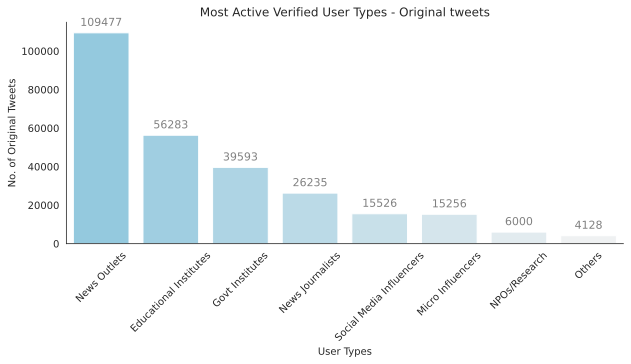

In [58]:
sns.set_style("white")
pastel_blue = sns.light_palette("skyblue", input="rgb", n_colors=8,reverse=True)
sns.set_palette(pastel_blue)

_, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
#sns.barplot(x='tweet_type',data=num_tweets, ax=axes, palette='pastel',order=num_tweets['count'].value_counts().index)

sns.barplot(x="user_type", y="count", data=type_tweets, palette=pastel_blue)

x_labels=['News Outlets','Educational Institutes','Govt Institutes','News Journalists','Social Media Influencers','Micro Influencers','NPOs/Research','Others']
axes.set_xticklabels(x_labels)

for p in axes.patches:
    axes.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                textcoords='offset points')

plt.title('Most Active Verified User Types - Original tweets')
plt.xlabel('User Types')
plt.ylabel('No. of Original Tweets')

sns.despine()
plt.xticks(rotation=45)

plt.show()


In [13]:
acc_tweet=twitter_df4_ver_user_2_origt.select('account_id','account_name','user_type').groupBy('account_id','account_name','user_type').count().orderBy(col('count').desc()).limit(10).toPandas()


In [16]:
acc_tweet.to_csv('acc_tweet.csv')

In [18]:
acc_tweet.head(10)

,account_id,account_name,user_type,count
0,19675956,ExploreLearning,Research_Inst,808
1,19616718,USNewsEducation,Educational_Inst,547
2,14662354,WashTimes,News_Journalist,545
3,78874095,tes,Educational_Inst,484
4,15147042,educationweek,Educational_Inst,427
5,30846824,TOICitiesNews,News_Outlet,425
6,23602600,timeshighered,Educational_Inst,406
7,3301029022,The74,Educational_Inst,368
8,1367531,FoxNews,News_Outlet,358
9,29447358,educationgadfly,Educational_Inst,352


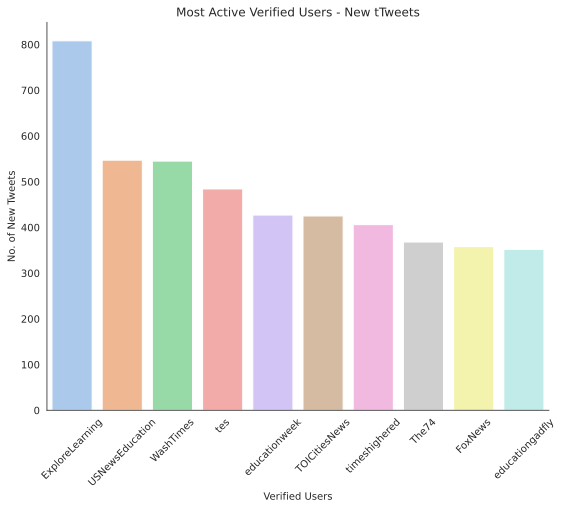

In [148]:
sns.set_style("white")

_, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 7))
#sns.barplot(x='tweet_type',data=num_tweets, ax=axes, palette='pastel',order=num_tweets['count'].value_counts().index)

sns.barplot(x="account_name", y="count", data=acc_tweet, palette="pastel",hue)

#axes.set_xticklabels(x_labels)

plt.title('Most Active Verified Users - New tTweets')
plt.xlabel('Verified Users')
plt.ylabel('No. of New Tweets')

sns.despine()
plt.xticks(rotation=45)

plt.show()



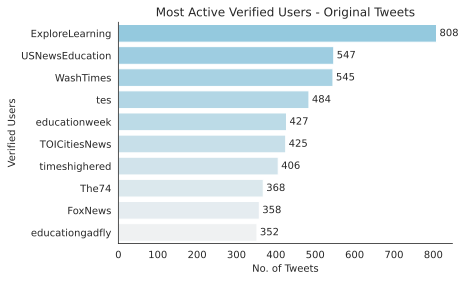

In [28]:
sns.set_style("white")
pastel_blue = sns.light_palette("skyblue", input="rgb", n_colors=10,reverse=True)
sns.set_palette(pastel_blue)


_, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

sns.barplot(y="account_name", x="count", data=acc_tweet, orient='h')

# for p in axes.patches:
#     axes.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
#                 textcoords='offset points')

for p in axes.patches:
    width = p.get_width()
    axes.annotate('{:.0f}'.format(width), xy=(width, p.get_y() + p.get_height() / 2),
                xytext=(3, 0), textcoords='offset points', ha='left', va='center')


plt.title('Most Active Verified Users - Original Tweets')

plt.xlabel('No. of Tweets')
plt.ylabel('Verified Users')


sns.despine()
plt.show()


### Analyzing Retweets

In [59]:
twitter_df4_ver_user_2_retweet=twitter_df4_ver_user_2.filter(col('tweet_type')=='retweet')
twitter_df4_ver_user_2_retweet.limit(10)

id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type,is_user_govt,is_user_news_outlet,is_user_news_journalist,is_user_edu,is_user_research,is_influencer,user_type
1539335995845402624,Tue Jun 21 19:54:...,RT @NSEAOnline: P...,public dollars sh...,null,null,null,null,null,false,true,RT,0,0,0,0,null,null,null,1539262288053833728,1539316518202138624,NSEAOnline,22789766,NEAToday,official account ...,Washington DC,true,247738,11834,4148,8048,27669,Wed Mar 04 15:51:...,https://pbs.twimg...,[],retweet,false,false,false,true,false,social_media_infl...,Educational_Inst
1539336083649048577,Tue Jun 21 19:54:...,RT @JasonBedrick:...,@wajahatali what ...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1539289355449028608,JasonBedrick,640893,EWErickson,you can listen ev...,"Atlanta, GA",true,205722,2700,4633,1384,14273,Mon Jan 15 22:54:...,https://pbs.twimg...,[],retweet,false,false,false,false,false,social_media_infl...,Influencer
1539336297814319104,Tue Jun 21 19:55:...,RT @itsSpencerBro...,scotus handed a b...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1539328635613630464,itsSpencerBrown,48459553,KatiePavlich,proud american wo...,On Instagram/Off ...,true,947092,2009,4472,18188,55802,Thu Jun 18 19:29:...,https://pbs.twimg...,[],retweet,false,false,false,false,false,social_media_infl...,Influencer
1539336562814623745,Tue Jun 21 19:56:...,RT @FOX8NOLA: One...,one of louisiana'...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1539336371936051200,FOX8NOLA,30950114,jessecbrooks,digital content p...,"New Orleans, LA",true,3442,1741,71,46045,82432,Mon Apr 13 20:23:...,https://pbs.twimg...,[],retweet,false,false,true,false,false,not_influencer,News_Journalist
1527065287517937664,Wed May 18 23:15:...,RT @Tjonesonthenb...,played against gr...,null,null,null,null,null,false,true,RT,0,0,0,0,null,null,null,1526583312638259201,1527021749052657665,Tjonesonthenba,291227103,Jacko2544,13 year pro baske...,"Philadelphia, PA",true,5893,355,74,4754,4001,Sun May 01 17:18:...,https://pbs.twimg...,[],retweet,false,true,true,true,false,micro_influencer,Educational_Inst
1527065966894624774,Wed May 18 23:17:...,RT @ChalkbeatNY: ...,will expanding ‘g...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1527063750116790272,ChalkbeatNY,20079575,the_zim,new york bureau c...,New York City,true,4077,1878,189,2735,10165,Wed Feb 04 18:55:...,https://pbs.twimg...,[],retweet,false,true,true,true,false,not_influencer,Educational_Inst
1527065971806150657,Wed May 18 23:17:...,RT @brownosaurusr...,how much trauma d...,null,null,null,null,null,false,true,RT,0,0,0,0,null,null,null,1526977426861039624,1527064314670206977,brownosaurusrex,1000899020,nandelabra,writer | bylines ...,Texas,true,7842,1008,110,347060,320553,Mon Dec 10 04:28:...,https://pbs.twimg...,[],retweet,false,true,true,false,false,micro_influencer,News_Journalist
1530319200690098178,Fri May 27 22:45:...,RT @thenewsoncnbc...,coming up on the ...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1530304006786097154,thenewsoncnbc,61539521,The_FineMan,tweeting news + i...,New York City,true,2391,2279,44,13981,27813,Thu Jul 30 17:06:...,https://pbs.twimg...,[],retweet,false,true,false,true,false,not_influencer,Educational_Inst
1530319602697351172,Fri May 27 22:46:...,RT @HoustonChron:...,after a gunman ki...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1530319227332317185,HoustonChron,2293485607,NRMoyle,texas longhorns b...,"Austin, TX",true,2575,943,145,1

In [60]:
type_retweets=twitter_df4_ver_user_2_retweet.select('user_type').groupBy('user_type').count().orderBy(col('count').desc()).limit(10).toPandas()

In [61]:
type_retweets

,user_type,count
0,Educational_Inst,55677
1,News_Journalist,47274
2,News_Outlet,40355
3,Government,36020
4,Micro_Influencer,17631
5,Influencer,12432
6,Others,6588
7,Research_Inst,5946


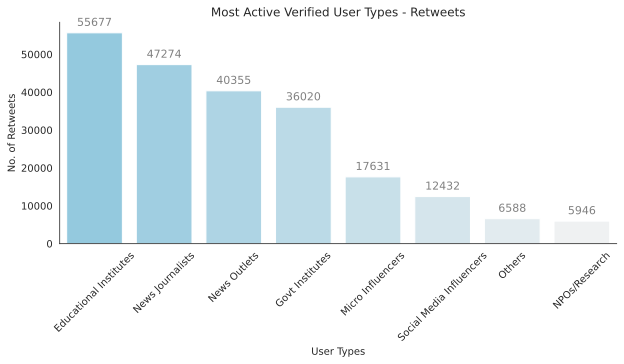

In [70]:
sns.set_style("white")
pastel_blue = sns.light_palette("skyblue", input="rgb", n_colors=8,reverse=True)
sns.set_palette(pastel_blue)

_, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
#sns.barplot(x='tweet_type',data=num_tweets, ax=axes, palette='pastel',order=num_tweets['count'].value_counts().index)

sns.barplot(x="user_type", y="count", data=type_retweets, palette=pastel_blue)

#axes.set_xticklabels(x_labels)

x_labels=['Educational Institutes','News Journalists','News Outlets'
          ,'Govt Institutes','Micro Influencers','Social Media Influencers','Others','NPOs/Research']

axes.set_xticklabels(x_labels)

for p in axes.patches:
    axes.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                textcoords='offset points')


plt.title('Most Active Verified User Types - Retweets')
plt.xlabel('User Types')
plt.ylabel('No. of Retweets')

sns.despine()
plt.xticks(rotation=45)

plt.show()



In [25]:
acc_retweets=twitter_df4_ver_user_2_retweet.select('account_id','account_name','user_type').groupBy('account_id','account_name','user_type').count().orderBy(col('count').desc()).limit(10).toPandas()

In [26]:
acc_retweets

,account_id,account_name,user_type,count
0,1276140426,DeAngelisCorey,Educational_Inst,2086
1,3317348164,NasimiShabnam,Government,649
2,92932981,JaneCaro,News_Journalist,357
3,14416109,alexanderrusso,Educational_Inst,344
4,42247052,AnsisEgle,Others,323
5,967003340595965952,ProAssam,Micro_Influencer,290
6,38647512,IndianExpress,News_Outlet,287
7,1472371170758512653,JonesHospodTX,Government,264
8,156306739,morgfair,Government,249
9,199399909,NicholasFerroni,Educational_Inst,247


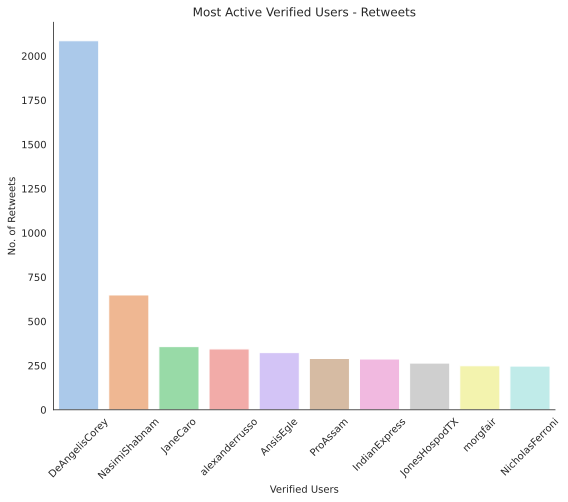

In [138]:
sns.set_style("white")

_, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 7))
#sns.barplot(x='tweet_type',data=num_tweets, ax=axes, palette='pastel',order=num_tweets['count'].value_counts().index)

sns.barplot(x="account_name", y="count", data=acc_retweets, palette="pastel")

#axes.set_xticklabels(x_labels)

plt.title('Most Active Verified Users - Retweets')
plt.xlabel('Verified Users')
plt.ylabel('No. of Retweets')

sns.despine()
plt.xticks(rotation=45)

plt.show()



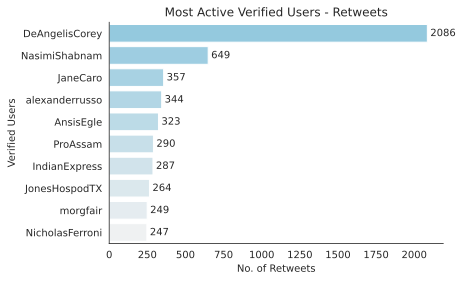

In [29]:
sns.set_style("white")
pastel_blue = sns.light_palette("skyblue", input="rgb", n_colors=10,reverse=True)
sns.set_palette(pastel_blue)


_, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

sns.barplot(y="account_name", x="count", data=acc_retweets, orient='h')

# for p in axes.patches:
#     axes.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
#                 textcoords='offset points')

for p in axes.patches:
    width = p.get_width()
    axes.annotate('{:.0f}'.format(width), xy=(width, p.get_y() + p.get_height() / 2),
                xytext=(3, 0), textcoords='offset points', ha='left', va='center')


plt.title('Most Active Verified Users - Retweets')

plt.xlabel('No. of Retweets')
plt.ylabel('Verified Users')


sns.despine()
plt.show()

### Most Retweeted Accounts

In [30]:
twitter_df4.limit(15)

id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type
1566378682318462976,Sun Sep 04 10:52:...,RT @C_A_Graham: H...,had another conve...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566034383559065601,C_A_Graham,483864332,erin_gilbey,Storyteller and 1...,"Birmingham, England",false,442,601,8,15433,8431,Sun Feb 05 13:37:...,https://pbs.twimg...,[],retweet
1566378688698097664,Sun Sep 04 10:52:...,RT @Oludeewon: I ...,i hope you have s...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566165377796771840,Oludeewon,984182548791164928,Odeshiye,♎ ...So A Child M...,Ghana,false,4902,4613,3,149571,92052,Wed Apr 11 21:32:...,https://pbs.twimg...,[],retweet
1566378715709427719,Sun Sep 04 10:52:...,RT @JackPosobiec:...,breaking: @trinit...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1565431877460189189,JackPosobiec,1558859689789644800,EuroAmerican87,American by birth...,Anywhere but here...,false,6,34,1,50,89,Sun Aug 14 16:54:...,https://pbs.twimg...,[],retweet
1566378716887916546,Sun Sep 04 10:52:...,RT @amishra77: Th...,the appalling con...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566378309520596993,amishra77,1279643153474224130,Bharath12450842,One of the 900 mi...,null,false,193,502,0,6244,9146,Sun Jul 05 05:09:...,https://pbs.twimg...,[],retweet
1566378724135555072,Sun Sep 04 10:52:...,RT @imzarvinnn: S...,senior high schoo...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566034947831660545,imzarvinnn,1530893925803622401,lvchdvmp,I'm counting on y...,archen's heart,false,341,458,0,11632,5624,Sun May 29 12:49:...,https://pbs.twimg...,[],retweet
1566378734529101824,Sun Sep 04 10:52:...,RT @imzarvinnn: S...,senior high schoo...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566034947831660545,imzarvinnn,1398282464854827012,doyiea_,she/her ...,null,false,1,91,0,59,621,Fri May 28 14:18:...,https://pbs.twimg...,[],retweet
1566378741508734976,Sun Sep 04 10:52:...,You can also tag ...,you can also tag ...,null,null,null,null,null,true,false,,0,0,0,0,1566378738438533120,1299666479344807937,thxteacher,null,null,null,1299666479344807937,thxteacher,Our Teachers are ...,null,false,902,69,1,325,1257,Sat Aug 29 11:13:...,https://pbs.twimg...,"[TeachersDay, Tha...",reply
1566378743710744576,Sun Sep 04 10:52:...,RT @cutedevil5934...,"""teachers play a ...",null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566366649912938498,cutedevil5934,769516988335067137,shoaibAlam28,http://Instagram....,"Jamui, India",false,85,146,0,1434,5245,Sat Aug 27 12:48:...,https://pbs.twimg...,[],retweet
1566378745539469312,Sun Sep 04 10:52:...,@jenqissante ! 🧚...,@jenqissante ! 🧚...,null,null,null,null,null,true,true,,0,0,0,0,1566373182810234882,1547185772708909056,jenqissante,1496397166339932162,null,null,1307586299893702656,PaperupPh,more than 1k+ wor...,10AM-10PM,false,520,182,2,95,820,Sun Sep 20 07:44:...,https://pbs.twimg...,[],quote
1566378750090027008,Sun Sep 04 10:52:...,RT @SethAbramson:...,like... one of hi...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566236400785264640,SethAbramson,1269070500082450437,ResisterNell,"Activist, #Resist...",Kentucky,false,9745,10379,16,463255,333552,Sat Jun 06 00:57:...,https://pbs.twimg...,[],retweet


In [31]:
twitter_df4_rt_all=twitter_df4.filter(col('is_retweeted')=='RT')
twitter_df4_rt_all.limit(5)

id,created_at,text,tweet_text,tweet_coordinates,tweet_country,tweet_country_code,tweet_place_full_name,tweet_place_type,is_reply,is_quote,is_retweeted,reply_count,quote_count,retweet_count,favorite_count,rp_original_id,rp_user_id,rp_original_user,qu_original_id,rt_original_id,rt_original_user,account_id,account_name,account_description,account_location,is_verified,total_followers,total_friends,total_listed,total_favourites,total_tweets,account_created_at,account_profile_picture,hashtags,tweet_type
1566378682318462976,Sun Sep 04 10:52:...,RT @C_A_Graham: H...,had another conve...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566034383559065601,C_A_Graham,483864332,erin_gilbey,Storyteller and 1...,"Birmingham, England",false,442,601,8,15433,8431,Sun Feb 05 13:37:...,https://pbs.twimg...,[],retweet
1566378688698097664,Sun Sep 04 10:52:...,RT @Oludeewon: I ...,i hope you have s...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566165377796771840,Oludeewon,984182548791164928,Odeshiye,♎ ...So A Child M...,Ghana,false,4902,4613,3,149571,92052,Wed Apr 11 21:32:...,https://pbs.twimg...,[],retweet
1566378715709427719,Sun Sep 04 10:52:...,RT @JackPosobiec:...,breaking: @trinit...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1565431877460189189,JackPosobiec,1558859689789644800,EuroAmerican87,American by birth...,Anywhere but here...,false,6,34,1,50,89,Sun Aug 14 16:54:...,https://pbs.twimg...,[],retweet
1566378716887916546,Sun Sep 04 10:52:...,RT @amishra77: Th...,the appalling con...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566378309520596993,amishra77,1279643153474224130,Bharath12450842,One of the 900 mi...,null,false,193,502,0,6244,9146,Sun Jul 05 05:09:...,https://pbs.twimg...,[],retweet
1566378724135555072,Sun Sep 04 10:52:...,RT @imzarvinnn: S...,senior high schoo...,null,null,null,null,null,false,false,RT,0,0,0,0,null,null,null,null,1566034947831660545,imzarvinnn,1530893925803622401,lvchdvmp,I'm counting on y...,archen's heart,false,341,458,0,11632,5624,Sun May 29 12:49:...,https://pbs.twimg...,[],retweet


In [37]:
acc_retweets_all=twitter_df4_rt_all\
.select('rt_original_id','rt_original_user','is_verified')\
.groupBy('rt_original_id','rt_original_user','is_verified').count().orderBy(col('count').desc()).limit(10).toPandas()

In [38]:
acc_retweets_all

,rt_original_id,rt_original_user,is_verified,count
0,1540348043328999424,thenyjew,False,26661
1,1530236616777900034,JessMcMasterKC,False,20642
2,1530026277373100033,davenewworld_2,False,19967
3,1529217542153199616,MoneyMiaaaa,False,19306
4,1613670054859804672,Travon,False,17380
5,1540338968490819584,LBJs_Johnson,False,16584
6,1524559937942212608,brndxq,False,15924
7,1531625547104673794,Mr_JCE,False,15362
8,1517225234578948102,javroar,False,14355
9,1529228352523059203,ChrChristensen,False,13841


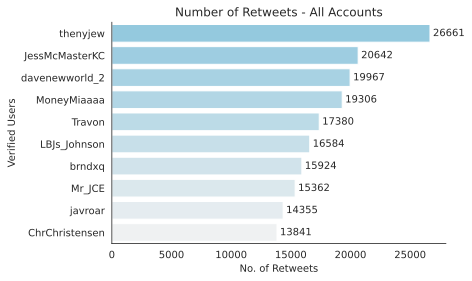

In [41]:
sns.set_style("white")
pastel_blue = sns.light_palette("skyblue", input="rgb", n_colors=10,reverse=True)
sns.set_palette(pastel_blue)

_, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

sns.barplot(y="rt_original_user", x="count", data=acc_retweets_all, orient='h')

# for p in axes.patches:
#     axes.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
#                 textcoords='offset points')

for p in axes.patches:
    width = p.get_width()
    axes.annotate('{:.0f}'.format(width), xy=(width, p.get_y() + p.get_height() / 2),
                xytext=(3, 0), textcoords='offset points', ha='left', va='center')


plt.title('Number of Retweets - All Accounts')

plt.xlabel('No. of Retweets')
plt.ylabel('Verified Users')


sns.despine()
plt.show()

In [44]:
acc_retweets_all[acc_retweets_all.is_verified==True]

,rt_original_id,rt_original_user,is_verified,count


In [45]:
acc_retweets_all_2=twitter_df4_rt_all\
.select('rt_original_id','rt_original_user','is_verified')\
.groupBy('rt_original_id','rt_original_user','is_verified').count().orderBy(col('count').desc())

In [46]:
acc_retweets_all_2.show(10)

+-------------------+----------------+-----------+-----+
|     rt_original_id|rt_original_user|is_verified|count|
+-------------------+----------------+-----------+-----+
|1540348043328999424|        thenyjew|      false|26661|
|1530236616777900034|  JessMcMasterKC|      false|20642|
|1530026277373100033|  davenewworld_2|      false|19967|
|1529217542153199616|     MoneyMiaaaa|      false|19306|
|1613670054859804672|          Travon|      false|17380|
|1540338968490819584|    LBJs_Johnson|      false|16584|
|1524559937942212608|          brndxq|      false|15924|
|1531625547104673794|          Mr_JCE|      false|15362|
|1517225234578948102|         javroar|      false|14355|
|1529228352523059203|  ChrChristensen|      false|13841|
+-------------------+----------------+-----------+-----+
only showing top 10 rows

